# Playlist Recommendation Using Collaborative Filtering and kNN

### CS109a - Introduction To Data Science 
### Final Project - Spotify Song Recommendation
### Group 20 - Erik Subatis, Mark McDonald, and Ankit Bhargava

In [425]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

import warnings
from IPython.display import clear_output

import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Summary

Collaborative filtering relies on similarities between user behavior to make predictions. In recommendation systems, a matrix is often encoded to represent user behavior. For this model, the matrix represents playlists (in rows) vs. songs that are present in a given playlist (in columns), where a 1 represents a song being present. Given the large volume of songs, this matrix is very sparse. 

This approach builds this sparse matrix using SKLearn's CountVectorizer and then uses cosine distance to make predictions using a k-nearest neighbors model. Recommendations are drawn from similar playlists while avoiding duplication with the input set. In short:

1. Build a sparse matrix for playlists X tracks
2. Fit a kNN model to this data using cosine distance
3. Find nearest playlists using this model given a list of songs
4. Select songs from nearest neighbor lists as recommendations

Two strategies are explored for selecting songs from the nearest neighbors. The first approach simply grabs songs from the closest neighbor(s) in order of proximity. The second approach counts the frequencies of song appearances among the selected neighbors, and recommends the most frequent songs in order.

The data is split into train and test sets, each consisting of a number of playlists. The model is built on the train set. Accuracy is assessed by feeding the model a portion each test set playlist, and checking the number of matches between what was recommended and the songs that were withheld from each test playlist (R-precision, as defined here: https://recsys-challenge.spotify.com/rules). This accuracy is averaged across all test playlists considered.

## Model Class

This class contains everything needed to run the collaborative filtering model via kNN as described above. It is used as follows:

1. Instantiate the CollaborativeFilteringKNN object by feeding it the training dataframe. It is assumed the DF has columns: playlist_id, track_uri, track_name, artist_uri,  artist_name. 

2. build_matrix() fits and transforms the training data into a binary sparse matrix using SKLearn's CountVectorizer. The matrix and vectorizer are stored internally. 

3. build_model() fits the kNN model to the matrix.

4. predict() takes the following arguments:
    - input_data: a dataframe containing the playlists to predict on (e.g. to 'seed' recommendation). should follow the same format as the training DF
    - num_recos: maximum recommendations to return per input playlist
    - strategy: 'closest_playlists' or 'frequency'
    - n_neighbors: how many neighboring playlists to consider given the model
    
   It returns a dictionary mapping given playlists -> a list of recommended song URIs for that playlist.
    
   
5. r_precision() can be used to calculate average accuracy by examining withheld songs from the input playlists given to predict(). It takes in the same kind of DF as described above, where the playlist_ids match the input_data given to predict() exactly, as well as the results of predict() (a dictionary).

In [426]:
''' This class contains all logic for building/implementing a Collaborative Filtering model via kNN
    for Spotify Playlist recommendation. Assumes a Playlist x Song matrix. '''

class CollaborativeFilteringKNN:
    
    ''' Takes the training data as a dataframe. 
        Columns expected: playlist_id, track_uri, track_name, artist_uri,  artist_name '''
    def __init__(self, train_data: pd.core.frame.DataFrame, init_model=True):
        print('Initializing CollaborativeFilteringKNN...')
        
        # constants in case column names change
        self.PREFIX = 'spotify:track:'
        self.PID = 'playlist_id'
        self.TRACK_URI = 'track_uri'
        
        self.train_df = train_data
        self.train_pids = train_data[self.PID].unique()
        
        if init_model:
            self.build_matrix()
            self.build_model()

    ''' Builds sparse matrix for song counts by playlist. '''
    def build_matrix(self):
        print('Building matrix...')
        
        # all vals are 1 or 0; stop_words omits the track URI prefix from each 'word'
        self.vectorizer = CountVectorizer(lowercase=False, binary=True, stop_words=['spotify', 'track']) 
        
        # corpus is built by concatenating all track URIs by playlist ID
        self.matrix = self.vectorizer.fit_transform(self.train_df.groupby([self.PID])[self.TRACK_URI].apply(' '.join))
        
    ''' Builds a kNN model using a sparse matrix. '''
    def build_model(self):
        print('Building kNN model...')
        self.model = NearestNeighbors(metric='cosine')
        self.model.fit(self.matrix)
        
    ''' Gets k neighbors for each playlist in a test set from model based on input. 
        Returns the INDICES of neighbors in the matrix, NOT playlist_ids. '''
    def get_neighbors(self, input_data: pd.core.frame.DataFrame, n_neighbors: int=5):
        # transform input data into sparse matrix (see build_matrix())
        print('Building input matrix...')
        input_matrix = self.vectorizer.transform(input_data.groupby([self.PID])[self.TRACK_URI].apply(' '.join))
        origin_pids = input_data[self.PID].unique()
    
        print('kneighbors running...')
        return self.model.kneighbors(input_matrix, n_neighbors=n_neighbors, return_distance=False), origin_pids
    
    ''' Gets song recommendations for a given playlist based on neighbors based on specified strategy.
        Returns a list of track URIs with prefix prepended to URI (e.g. as in the original DF).
        Mostly a utility method for predict() -- see below. '''
    def get_recos_for_playlist(self, origin_playlist: list, neighbors: list, strategy: str='closest_playlists', num_recos: int=10):
        recos = []
        origin_playlist = set(origin_playlist)
        
        # Closest playlists - this strategy simply pulls non-overlapping songs from the closest neighbors, in order.
        if strategy == 'closest_playlists':
            for i in neighbors:
                pid = self.train_pids[i] # index into proper playlist_id
                cur_playlist = self.train_df.loc[self.train_df[self.PID] == pid][self.TRACK_URI].tolist()
                for track in cur_playlist:
                    if track not in origin_playlist:
                        recos.append(track)
                    if len(recos) == num_recos:
                        break
                        
                if len(recos) == num_recos:
                        break    
                        
            return recos
            
        # Frequency - this strategy sums up appearences of songs in neighbor playlists and returns the most common songs
        elif strategy == 'frequency':
            # get dataframe of neighbors and count song occurrences
            neighbor_pids = [self.train_pids[i] for i in neighbors]
            neighbors_df = self.train_df[self.train_df[self.PID].isin(neighbor_pids)]
            tracks = neighbors_df[self.TRACK_URI].value_counts()
            
            for track, count in tracks.items():
                if track not in origin_playlist:
                    recos.append(track)
                if len(recos) == num_recos:
                    break
                
            return recos

        else:
            print(f'get_recos_for_playlist(origin_pid={origin_pid}): No or invalid strategy selected for recommendation.')
            return
        
    ''' Recommends songs based on neighbors (given by get_neighbors, above).
        Returns a dict of original pid -> lists of URIs formatted exactly as-is in the Spotify data (e.g. with prefix).
        
        Options allow different methods of selecting songs from neighbors. Must choose at least one method:
        
        closest_playlists (default) - Selects songs from the closest playlist(s) until num_songs is reached 
        frequency                   - Selects songs from neighbors based on frequency of song appearences '''
    def predict(self, input_data: pd.core.frame.DataFrame, num_recos: int=10, strategy: str='closest_playlists', n_neighbors=5): 
        print('Retrieving neighbors...')
        neighbors, origin_pids = self.get_neighbors(input_data, n_neighbors=n_neighbors)
        recommendations = {}
        
        for i, pid in enumerate(origin_pids):
            # show progress, as this can take awhile
            clear_output()
            print('Progress:', i, '/', len(origin_pids))
            
            origin_playlist = input_data[input_data[self.PID] == pid][self.TRACK_URI].tolist()
            recos = self.get_recos_for_playlist(origin_playlist, neighbors[i], strategy=strategy, num_recos=num_recos)
            recommendations[pid] = recos
        
        return recommendations
    
    ''' Calculates R-precision by dividing matches / withheld tracks and averaging for each test list.
        Val_df playlist IDs should match what is in the recos dict. '''
    def r_precision(self, val_df: pd.core.frame.DataFrame, recos: dict):
        accs = []
        for pid, predicted_tracks in recos.items():
            withheld_tracks = val_df[val_df[self.PID] == pid][self.TRACK_URI].tolist()
            matches = list(set(withheld_tracks) & set(predicted_tracks))
            score = len(matches) / len(withheld_tracks)
            accs.append(score)
        
        return np.mean(accs)
    
    # helper to display track info. Note that artist_uri and artist_name were switched in this DF by accident
    # but it was inconsequential for the results.
    def display_track_info(self, df: pd.core.frame.DataFrame, uri: str):
        track = df[df[self.TRACK_URI] == uri].iloc[0]
        print(track.artist_uri, '-', track.track_name)

## Training Data

The training data contains the vast majority of the staff-provided Spotify playlists data. 

In [427]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df_playlists_train = pd.read_csv('../data/df_playlists_train.csv', index_col='index')
    
# for reference:
# FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
#   mask |= (ar1 == a)

In [428]:
df_playlists_train.head()

,Unnamed: 0,playlist_id,track_uri,track_name,artist_name,artist_uri
index,,,,,,
0,0,1,spotify:track:2d7LPtieXdIYzf7yHPooWd,Chasing Cars,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Sleeping At Last
1,1,1,spotify:track:0y4TKcc7p2H6P0GJlt01EI,Elephants,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Rachael Yamagata
2,2,1,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,That Home,spotify:artist:32ogthv0BdaSMPml02X9YB,The Cinematic Orchestra
3,3,1,spotify:track:54KFQB6N4pn926IUUYZGzK,To Build A Home,spotify:artist:32ogthv0BdaSMPml02X9YB,The Cinematic Orchestra
4,4,1,spotify:track:0NeJjNlprGfZpeX2LQuN6c,River,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,Leon Bridges


In [429]:
print('Number of training playlists:', len(df_playlists_train['playlist_id'].unique()))

Number of training playlists: 989001


## Build & Train a Model

In [430]:
model = CollaborativeFilteringKNN(train_data=df_playlists_train, init_model=False)

Initializing CollaborativeFilteringKNN...


In [431]:
model.build_matrix()

Building matrix...


In [432]:
model.build_model()

Building kNN model...


In [433]:
model.model

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## Test Data

The test data consists of the remaining playlists from the complete Spotify data set not included in the training data. It is split into 2 pieces: portions of each test playlist that we will feed the model in order to predict tracks, and the other portions of each test playlist that we will use benchmark these predictions.

In [434]:
df_playlists_test_given = pd.read_csv('../data/df_playlists_test_given.csv', index_col='index')
df_playlists_test_withheld = pd.read_csv('../data/df_playlists_test_withheld.csv', index_col='index')

In [435]:
display(df_playlists_test_given.head())
display(df_playlists_test_withheld.head())

,playlist_id,track_uri,track_name,artist_name,artist_uri
index,,,,,
23255,358,spotify:track:2xt2piJx6jlFkjS77YiqpL,Like a Stone,spotify:artist:2ziB7fzrXBoh1HUPS6sVFn,Audioslave
23256,358,spotify:track:21tuvt3CXIsNquc32v8jpc,Show Me How to Live,spotify:artist:2ziB7fzrXBoh1HUPS6sVFn,Audioslave
23257,358,spotify:track:7w87IxuO7BDcJ3YUqCyMTT,Pumped Up Kicks,spotify:artist:7gP3bB2nilZXLfPHJhMdvc,Foster The People
23258,358,spotify:track:6b2oQwSGFkzsMtQruIWm2p,Creep,spotify:artist:4Z8W4fKeB5YxbusRsdQVPb,Radiohead
23259,358,spotify:track:2takcwOaAZWiXQijPHIx7B,Time Is Running Out,spotify:artist:12Chz98pHFMPJEknJQMWvI,Muse


,playlist_id,track_uri,track_name,artist_name,artist_uri
index,,,,,
23410,358,spotify:track:4cQIbDqCZrHknxlDUjRHZ0,Supersoaker,spotify:artist:2qk9voo8llSGYcZ6xrBzKx,Kings of Leon
23409,358,spotify:track:4QQg6DXsx6G3lv3W4A15CZ,Recover,spotify:artist:3CjlHNtplJyTf9npxaPl5w,CHVRCHES
23290,358,spotify:track:5jafMI8FLibnjkYTZ33m0c,High And Dry,spotify:artist:4Z8W4fKeB5YxbusRsdQVPb,Radiohead
23265,358,spotify:track:76Je5Wklky23mVoxiRszcN,Walk,spotify:artist:7jy3rLJdDQY21OgRLCZ9sD,Foo Fighters
23268,358,spotify:track:5OQsiBsky2k2kDKy2bX2eT,Learn to Fly,spotify:artist:7jy3rLJdDQY21OgRLCZ9sD,Foo Fighters


In [436]:
print('Number of test playlists:', len(df_playlists_test_given['playlist_id'].unique()))

Number of test playlists: 10000


## Make Predictions

There are a couple of dimensions to play with to build predictions for the test set:
- Number of neighbors considered
- Number of recommendations to make
- Strategy for recommendations (closest playlists vs frequency of songs among neighbors)

We use the Spotify Recsys-inspired convention of making (up to) 500 recommendations per test playlist. From there, we explore the implications of varied k-values for neighbors for each strategy. 

We test accuracy against 100 randomly selected test playlists for performance/speed considerations.

In [464]:
N_TEST_PLAYLISTS = 100
K_VALS = [ 1, 5, 10, 20, 30, 40, 50, 75, 100 ]

In [459]:
test_playlist_ids = np.random.choice(df_playlists_test_given['playlist_id'].unique(), N_TEST_PLAYLISTS, replace=False)

test_df_given = df_playlists_test_given[df_playlists_test_given['playlist_id'].isin(test_playlist_ids)]
test_df_withheld = df_playlists_test_withheld[df_playlists_test_withheld['playlist_id'].isin(test_playlist_ids)]

In [462]:
print(len(test_df_given['playlist_id'].unique()))
print(len(test_df_withheld['playlist_id'].unique()))

display(test_df_given.head())
display(test_df_withheld.head())

100
100


,playlist_id,track_uri,track_name,artist_name,artist_uri
index,,,,,
143276,2188,spotify:track:5f4Y1zAYIinYJV5TlZgKLt,Hot As You Want,spotify:artist:27gtK7m9vYwCyJ04zz0kIb,Lane 8
143278,2188,spotify:track:7lfrMwa8FtTtI7uub3w03Q,Poolside,spotify:artist:28yVvEvA2lT3K5RNIhV1Dj,BAYNK
143279,2188,spotify:track:6yMxfx9wpiuhhdb8vHDVMu,Whatever You Need (feat. Chris Brown & Ty Doll...,spotify:artist:20sxb77xiYeusSH8cVdatc,Meek Mill
143280,2188,spotify:track:67SdUpnALp42jMq0mATVYV,Dust,spotify:artist:14DGJVYmuwwsdHmW8a02eM,Antony & Cleopatra
143281,2188,spotify:track:31mgN2XJGaP0Y0BtJquRQY,Spoonful,spotify:artist:7mZgBMpvaBziYQfc9TbJH5,Benjamin Booker


,playlist_id,track_uri,track_name,artist_name,artist_uri
index,,,,,
143276,2188,spotify:track:5f4Y1zAYIinYJV5TlZgKLt,Hot As You Want,spotify:artist:27gtK7m9vYwCyJ04zz0kIb,Lane 8
143278,2188,spotify:track:7lfrMwa8FtTtI7uub3w03Q,Poolside,spotify:artist:28yVvEvA2lT3K5RNIhV1Dj,BAYNK
143279,2188,spotify:track:6yMxfx9wpiuhhdb8vHDVMu,Whatever You Need (feat. Chris Brown & Ty Doll...,spotify:artist:20sxb77xiYeusSH8cVdatc,Meek Mill
143280,2188,spotify:track:67SdUpnALp42jMq0mATVYV,Dust,spotify:artist:14DGJVYmuwwsdHmW8a02eM,Antony & Cleopatra
143281,2188,spotify:track:31mgN2XJGaP0Y0BtJquRQY,Spoonful,spotify:artist:7mZgBMpvaBziYQfc9TbJH5,Benjamin Booker


#### Closest Playlist Approach

This somewhat "naive" approach simply pulls songs from the closest neighboring playlist(s).

In [465]:
closest_accs = {}
for k in K_VALS:
    preds = model.predict(test_df_given, num_recos=500, strategy='closest_playlists', n_neighbors=k)
    closest_accs[k] = model.r_precision(test_df_withheld, preds)

Progress: 99 / 100


In [466]:
closest_accs

{1: 0.16400000000000003,
 5: 0.325,
 10: 0.38300000000000006,
 20: 0.408,
 30: 0.4159999999999999,
 40: 0.419,
 50: 0.42100000000000004,
 75: 0.42100000000000004,
 100: 0.42100000000000004}

#### Frequent Appearences Approach

This approach tallies up the number of times tracks appear among 'k' neighbor playlists and recommends the most frequent songs.

In [467]:
frequency_accs = {}
for k in K_VALS:
    preds = model.predict(test_df_given, num_recos=500, strategy='frequency', n_neighbors=k)
    frequency_accs[k] = model.r_precision(test_df_withheld, preds)

Progress: 99 / 100


In [468]:
frequency_accs

{1: 0.16400000000000003,
 5: 0.326,
 10: 0.39799999999999996,
 20: 0.44599999999999995,
 30: 0.47499999999999987,
 40: 0.49699999999999994,
 50: 0.509,
 75: 0.52,
 100: 0.517}

## Assess and Visualize Accuracy

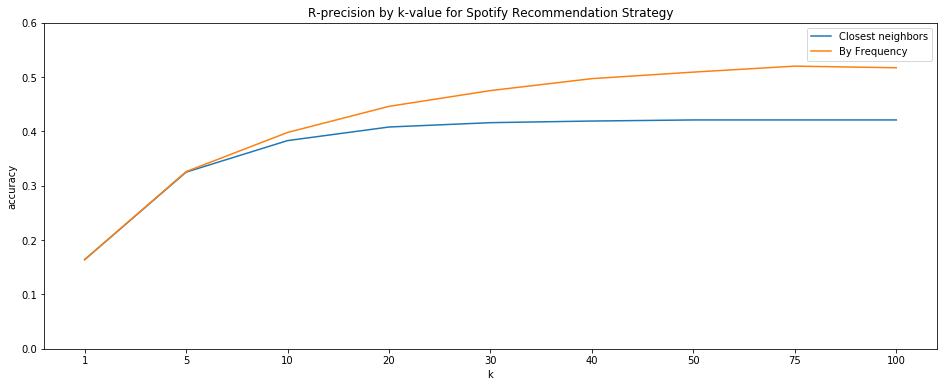

In [479]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# plot accuracy for each strategy by k
ax.plot(np.arange(9), list(closest_accs.values()), label='Closest neighbors')
ax.plot(np.arange(9), list(frequency_accs.values()), label='By Frequency')

ax.set_title('R-precision by k-value for Spotify Recommendation Strategy')
ax.set_ylabel('accuracy')
ax.set_xlabel('k')
ax.set_ylim(0.0, 0.60)
ax.set(xticks=range(9), xticklabels=K_VALS)
ax.legend();

Accuracy increases with greater value of k up to a point. The closest neighbors approach flattens, presumably as it begins to have enough available playlists to consistently draw 500 recommendations--the method is deterministic in that it will always choose the same songs for the test set once it has enough neighbors to choose from (since it is purely based on playlist proximity). The frequent song approach quickly outperforms the closest neighbors approach, granting R-precision of >50%, and appears optimal around the k=75 range.

## Conclusion

The model is ultimately based on the assumption that users with similar playlists will share preferences, so we can recommend songs from some users' playlist to another user. By building a sparse matrix designating which songs appear in which playlists, we can fit a kNN model to analyze playlist similarity. The questions then become how to tune this initial model to select the appropriate number of similar playlists, and what strategy to use to draw on this pool of neighboring playlists.

We see that reasonably large k tends to benefit song recommendation. Even for the 'naive' strategy we need a sufficient number of neighbors to pull enough recommendations, and we see even greater improvent by further analyzing song frequency. It is noteworthy that this implementation takes a fairly long time to run recommendations for large numbers of data sets. SKLearn's kNN model doesn't appear well-suited toward large matrices. That said, even though we used the entire training data set here, earlier testing suggested that we could achieve solid results by training with just a portion of the data. The song recommendation strategies here were also rather slow, but that could likely be improved.

One could envision further 'filtering' on the neighboring playlists to boost accuracy. For example, leveraging song features via the Spotify API, popularity, or other metrics could add another dimension to song recommendation. 